# Timing the transforms
Can we compare the time complexity of our transforms?

Problem: $\text{argmin}_{x \in \mathcal{C}} \| Ax - b \|^2$ can be written as...

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import lib
from lib import CountSketch, SRHT, GaussianSketch
from scipy import sparse

import itertools
from timeit import default_timer
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(10)

In [2]:
def test_time_sparsity(n_rows, n_cols, n_trials, sketch_size, densities):
    '''
    Function to automate the experiments measuring time 
    and varying sparsity for given input data.
    
    Inputs: n_rows, n_cols, n_trials, sketch_size all int
            densities - list of densities to try
            
    Output: Two dictionaries with key as density value tested and
    then the times associated with testing that experiment.
    One dict for CWT and one for SRHT.'''
    rho_str = [str(density) for density in densities]
    CWT_time = {}
    SRHT_time = {}


    for density in densities:
        X = sparse.random(n_rows,n_cols,density).toarray()
        print('Testing density', density)
        for trial in range(n_trials):
            print("Trial no. ", trial)
            CWT_summary_time = 0
            SRHT_summary_time = 0
    
            start = default_timer()
            CWT_summary = CountSketch(data=X, sketch_dimension=sketch_size,random_state=10)
            CWT_sketch = CWT_summary.sketch(X)
            CWT_summary_time += default_timer() - start
        
    
            start = default_timer()
            SRHT_summary = SRHT(data=X, sketch_dimension=sketch_size,random_state=10)
            SRHT_sketch = SRHT_summary.sketch(X)
            SRHT_summary_time = default_timer() - start
    
        CWT_time[str(density)] = CWT_summary_time/n_trials
        SRHT_time[str(density)] = SRHT_summary_time/n_trials
    
    return CWT_time, SRHT_time

In [3]:
# Quick test to make sure both working
# .toarray() convert to numpy array for the SRHT
A = sparse.random(5000,100, 0.25).toarray() 
x = np.random.randn(A.shape[1])
sketch_size = 500

# Sketching
CWT_summary = CountSketch(data=A, sketch_dimension=sketch_size,random_state=10)
CWT_A = CWT_summary.sketch(A)


SRHT_summary = SRHT(data=A, sketch_dimension=sketch_size,random_state=10)
SRHT_A = SRHT_summary.sketch(A)


# norm preservation
true_mat_vec_norm = np.linalg.norm(A@x)**2
true_mat_mat_norm = np.linalg.norm(A.T@A, ord='fro')**2

CWT_mat_vec_norm = np.linalg.norm(CWT_A@x)**2
CWT_mat_mat_norm = np.linalg.norm(CWT_A.T@CWT_A, ord='fro')**2

CWT_mat_vec_rel_error = CWT_mat_vec_norm / true_mat_vec_norm
CWT_mat_mat_rel_error = CWT_mat_mat_norm / true_mat_mat_norm

SRHT_mat_vec_norm = np.linalg.norm(SRHT_A@x)**2
SRHT_mat_mat_norm = np.linalg.norm(SRHT_A.T@SRHT_A, ord='fro')**2

SRHT_mat_vec_rel_error = SRHT_mat_vec_norm / true_mat_vec_norm
SRHT_mat_mat_rel_error = SRHT_mat_mat_norm / CWT_mat_mat_norm

print("CWT")
print("Inner product relative error: {}".format(CWT_mat_vec_rel_error))
print("Hessian matrix relative error: {}".format(CWT_mat_mat_rel_error))
print("--"*25)
print("SRHT")
print("Inner product relative error: {}".format(SRHT_mat_vec_rel_error))
print("Hessian matrix relative error: {}".format(SRHT_mat_mat_rel_error))

CWT
Inner product relative error: 1.0049789709922903
Hessian matrix relative error: 1.1524750492888323
--------------------------------------------------
SRHT
Inner product relative error: 1.0641560762284943
Hessian matrix relative error: 0.9181200277700535


In [4]:
# Control parameters
n,d = 100000, 50
data_densities = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
sketch_size = 500

num_trials = 5


# Measurable times
rho_str = [str(density) for density in data_densities]
CWT_time = {}
SRHT_time = {}


for density in data_densities:
    A = sparse.random(n,d,density).toarray()
    print('Testing density', density)
    for trial in range(num_trials):
        print("Trial no. ", trial)
        CWT_summary_time = 0
        SRHT_summary_time = 0
    
        
        CWT_summary = CountSketch(data=A, sketch_dimension=sketch_size,random_state=10)
        start = default_timer()
        CWT_A = CWT_summary.sketch(A)
        CWT_summary_time += default_timer() - start
        
    
        SRHT_summary = SRHT(data=A, sketch_dimension=sketch_size,random_state=10)
        start = default_timer()
        SRHT_A = SRHT_summary.sketch(A)
        SRHT_summary_time = default_timer() - start
    
    CWT_time[str(density)] = CWT_summary_time/num_trials
    SRHT_time[str(density)] = SRHT_summary_time/num_trials

Testing density 0.01
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.05
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.1
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.25
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.5
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.75
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 1.0
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4


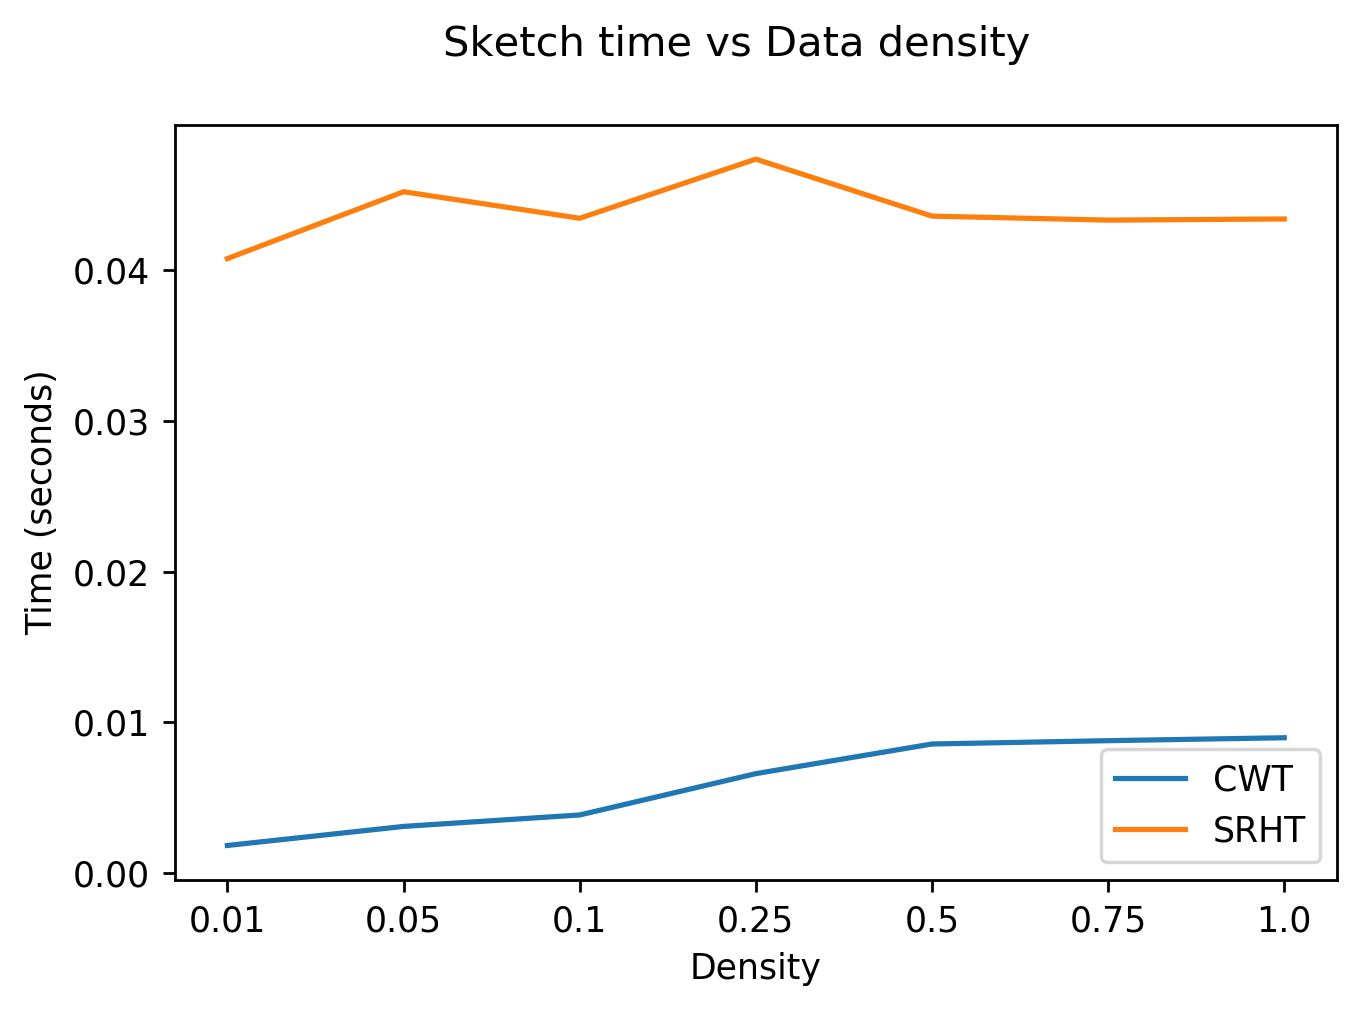

In [5]:
fig, ax = plt.subplots(dpi=250, facecolor='w', edgecolor='k')
fig.suptitle("Sketch time vs Data density")
ax.plot(*zip(*sorted(CWT_time.items())), label='CWT')
ax.plot(*zip(*sorted(SRHT_time.items())), label='SRHT')
ax.set_xlabel("Density")
ax.set_ylabel("Time (seconds)")
ax.legend()

In [6]:
param_grid = {
    'num trials' : 5,
    'rows' : [100000],
    'columns' : [10, 100, 500],#1000, 2000],
    'density' : [0.01, 0.1, 0.25, 0.5, 1.0]
}

results = {}

for n_rows, n_cols in itertools.product(param_grid['rows'], param_grid['columns']):
    n_trials = param_grid['num trials']
    print('Testing design matrix ({},{})'.format(n_rows, n_cols))
    sketch_size = 10*n_cols
    C_T, S_T =  test_time_sparsity(n_rows, n_cols, n_trials,sketch_size,param_grid['density'])
    results[(n_rows, n_cols, "CWT")] = C_T
    results[(n_rows, n_cols, "SRHT")] = S_T
    

Testing design matrix (100000,10)
Testing density 0.01
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.1
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.25
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.5
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 1.0
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing design matrix (100000,100)
Testing density 0.01
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.1
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.25
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.5
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 1.0
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing design matrix (100000,500)
Testing density 0.01
Trial no.  0
Trial no

(100000, 10, 'CWT')
(100000, 10, 'SRHT')
(100000, 100, 'CWT')
(100000, 100, 'SRHT')
(100000, 500, 'CWT')
(100000, 500, 'SRHT')


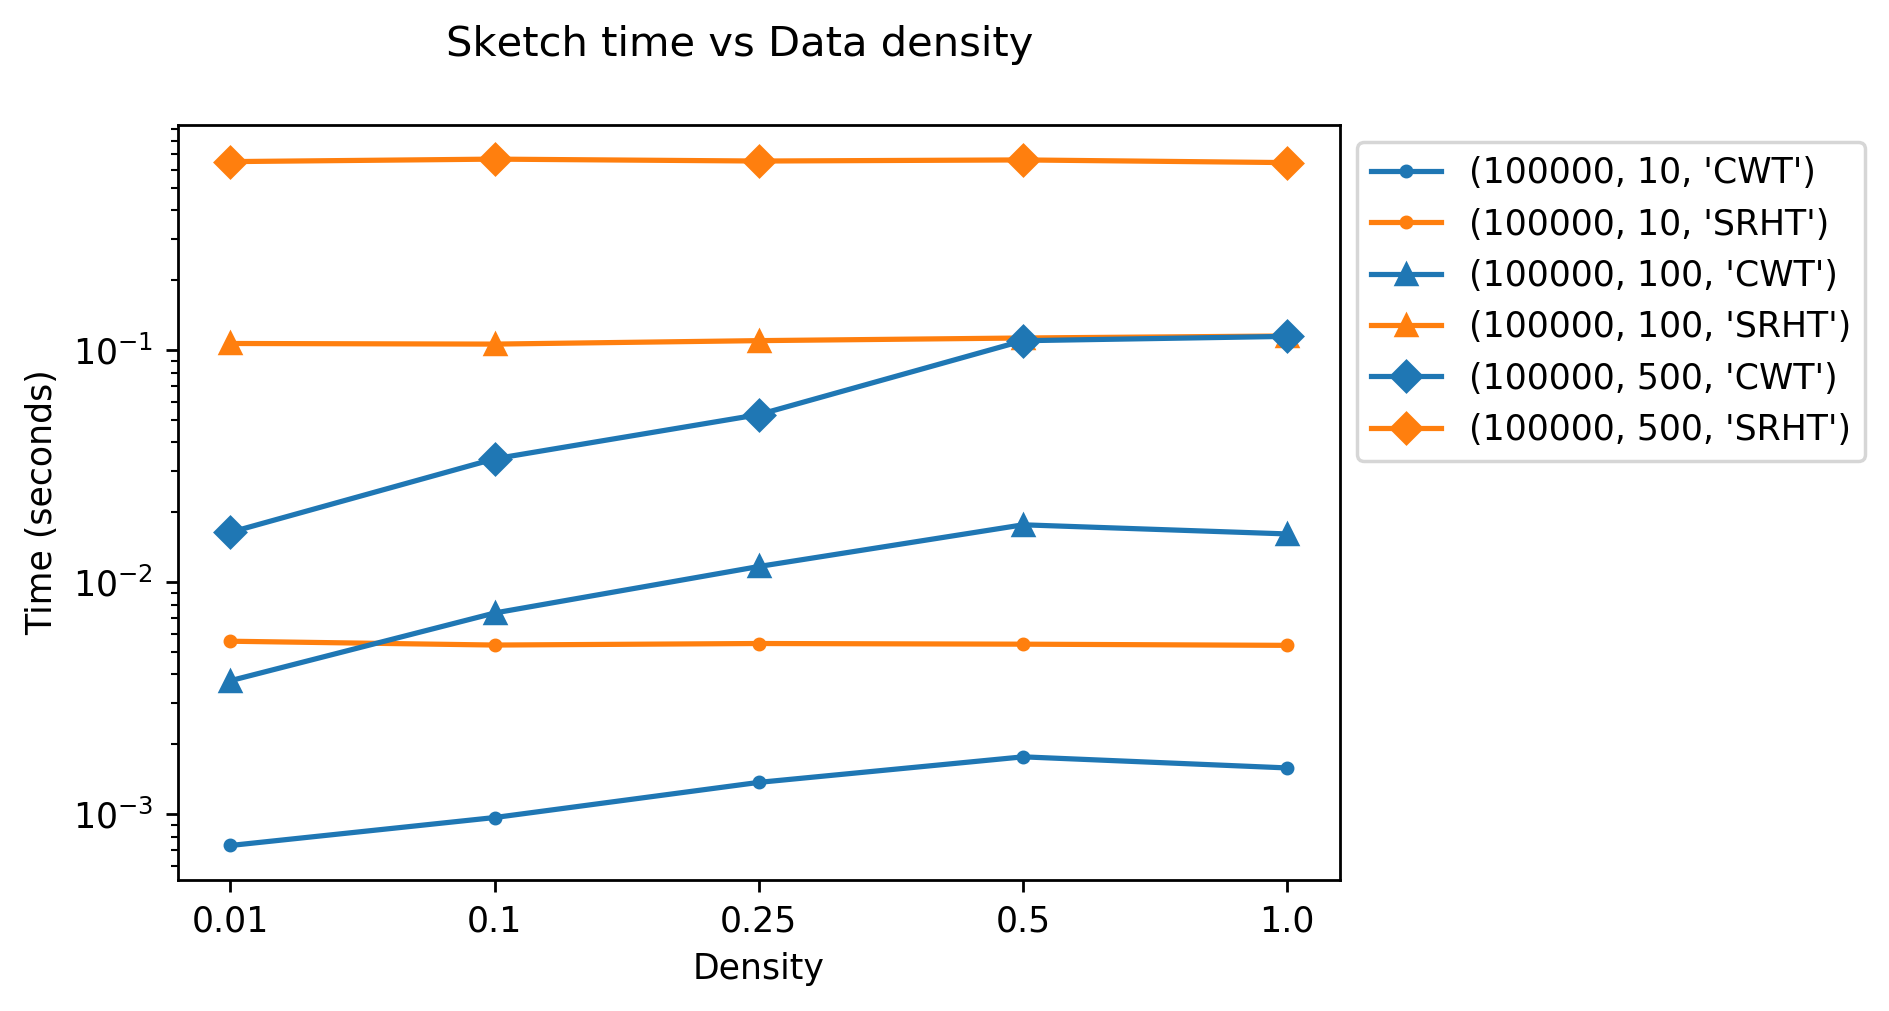

In [7]:
markers = {10: '.', 100 : '^', 250 : 's',
           500 : 'D', 1000: 'x', 2000: '*'}
fig, ax = plt.subplots(dpi=250, facecolor='w', edgecolor='k')
fig.suptitle("Sketch time vs Data density")

for parameters in results.keys():
    print(parameters)
    n = int(parameters[0])
    d = int(parameters[1])
    method = parameters[2]
    
    
    if method == 'CWT':
        col = 'C0'
    else:
        col = 'C1'
        
    
    ax.plot(*zip(*sorted(results[parameters].items())),
            label=(parameters), color=col, marker=markers[d])
    
handles,labels = ax.get_legend_handles_labels()
#labels = [labels[0], labels[2], labels[4], labels[6],
#          labels[1], labels[3], labels[5], labels[7]]
#handles = [handles[0], handles[2], handles[4], handles[6],
#           handles[1], handles[3], handles[5], handles[7]]
ax.set_yscale('log')
ax.set_xlabel("Density")
ax.set_ylabel("Time (seconds)")
#ax.grid()
ax.legend(handles, labels, bbox_to_anchor=(1.0, 1.0))